In [4]:
import warnings
import json
import pandas as pd
import torch
import random
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import AutoModelForMaskedLM, AutoTokenizer, DataCollatorForLanguageModeling, Trainer, TrainingArguments

## citation_sentiment_corpus.csv

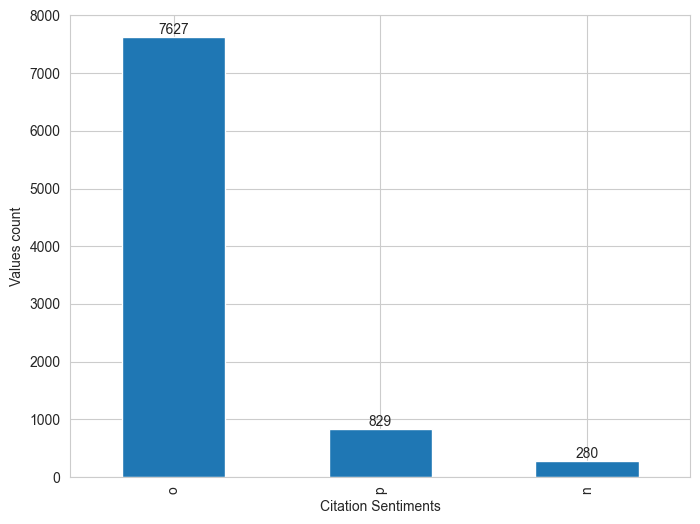

In [5]:
raw_df = pd.read_csv('citation_sentiment_corpus.csv')
fig, ax = plt.subplots(figsize=(8,6))
raw_df.Sentiment.value_counts().plot(kind = 'bar',ax=ax)
for i, count in enumerate(raw_df.Sentiment.value_counts()):
    ax.text(i, count, str(count), ha='center', va='bottom')
plt.xlabel('Citation Sentiments')
plt.ylabel('Values count')
plt.show()

## controllable-citation-generation

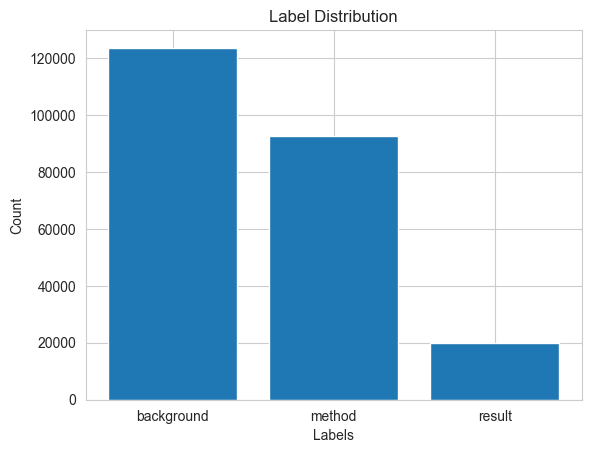

Label counts: {'background': 123605, 'method': 92454, 'result': 19936}


In [6]:
label2id = {"background": 0, "method": 1, "result": 2}
id2label = {v: k for k, v in label2id.items()}

def read_jsonl(file_path):
    citations = []
    intents = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            entry = json.loads(line.strip())
            citation = entry.get('citation')
            citation_intent = entry.get('citation_intent')
            if citation and citation_intent:
                citation_intent_id = label2id.get(citation_intent, -1)  # Use -1 for unknown labels
                citations.append(citation)
                intents.append(citation_intent_id)
    return citations, intents

train_citations, train_intents = read_jsonl('controllable-citation-generation/train.jsonl')
test_citations, test_intents = read_jsonl('controllable-citation-generation/test.jsonl')
val_citations, val_intents = read_jsonl('controllable-citation-generation/val.jsonl')
data = train_intents + test_intents + val_intents

label_counts = Counter(data)
labels, counts = zip(*label_counts.items())
labels = [id2label[label] for label in labels]

plt.bar(labels, counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.show()

print("Label counts:", dict(zip(labels, counts)))

## citation_sentiment_corpus_balanced.csv

In [7]:
DATA_PATH = 'citation_sentiment_corpus_balanced.csv'
df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head()

(7720, 3)


,Citation_Text,Sentiment,Source
0,…for ovarian and other similar cancer cell lin...,1,original
1,akov and Hearst solved relational similarity...,1,original
2,Steps 3 to 3 can be done efficiently using t...,1,original
3,Our model exploits the same kind of tag-n-gram...,1,original
4,Standard sequence prediction models are highly...,1,original


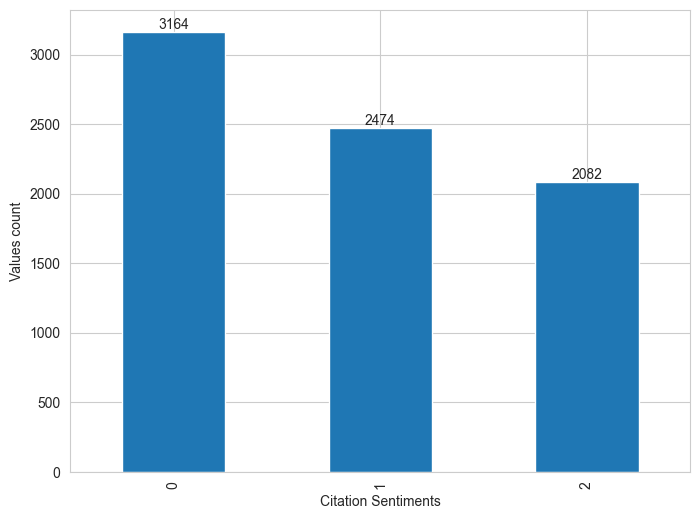

In [8]:
fig, ax = plt.subplots(figsize=(8,6))
df.Sentiment.value_counts().plot(kind = 'bar',ax=ax)
for i, count in enumerate(df.Sentiment.value_counts()):
    ax.text(i, count, str(count), ha='center', va='bottom')
plt.xlabel('Citation Sentiments')
plt.ylabel('Values count')
plt.show()

## corpus.txt

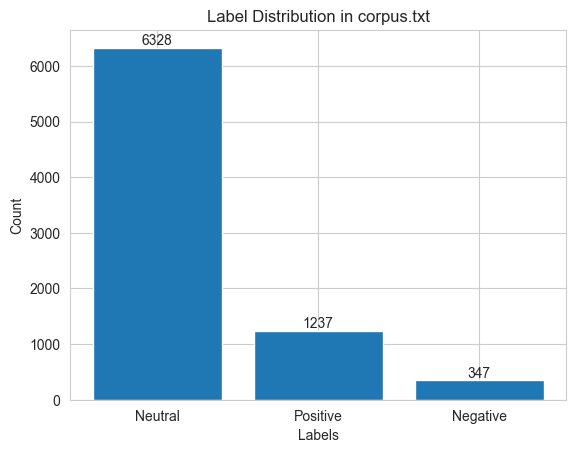

In [9]:
import matplotlib.pyplot as plt
from collections import Counter

def count_labels(filepath):
    label_counter = Counter()
    with open(filepath, "r", encoding="utf8") as f:
        file = f.read().split("\n")
        file = [i.split("\t") for i in file]
        for i in file:
            if len(i) == 2:
                label = int(i[0])
                # Map labels: 2 -> Positive, 1 -> Neutral, 0 -> Negative
                if label == 2:
                    label = 1
                elif label == 1:
                    label = 0
                elif label == 0:
                    label = 2
                label_counter[label] += 1
    return label_counter

# Example usage
filepath = 'corpus.txt'
label_counts = count_labels(filepath)

# Plotting the bar chart
labels, counts = zip(*label_counts.items())
label_names = ['Neutral', 'Positive', 'Negative']
label_names = [label_names[label] for label in labels]

plt.bar(label_names, counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution in corpus.txt')

# Annotate the counts on top of the bars
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

In [12]:
import pandas as pd

def txt_to_csv(filepath, output_csv):
    sentences, labels = [], []
    with open(filepath, "r", encoding="utf8") as f:
        file = f.read().split("\n")
        file = [i.split("\t") for i in file]
        for i in file:
            if len(i) == 2:
                sentence = i[1]
                label = int(i[0])
                # Map labels: 2 -> Positive, 1 -> Neutral, 0 -> Negative
                if label == 2:
                    label = 1
                elif label == 1:
                    label = 0
                elif label == 0:
                    label = 2
                sentences.append(sentence)
                labels.append(label)
    
    # Create a DataFrame and save to CSV
    df = pd.DataFrame({'Sentiment': labels, 'Citation_Text': sentences})
    df.to_csv(output_csv, index=False)

# Example usage
# txt_to_csv('corpus.txt', 'corpus.csv')
# df = pd.read_csv('corpus.csv')
# df.head(20)

## train_data_aug1.csv

In [13]:
df_aug = pd.read_csv('train_data_aug1.csv')
df_aug.head(20)

,Citation_Text,Sentiment,Source
0,"Recently, an elegant approach to inference in ...",1,original
1,provide a promising physical framework to rati...,1,original
2,Among the most widely studied is the Gibbs dis...,1,original
3,Many techniques for bone defatting are describ...,1,original
4,Sentences are parsed using the MST dependency ...,1,original
5,"In particular, presents very strong results ...",1,original
6,The limitations of the generative approach to ...,1,original
7,The most commonly used MT evaluation metric in...,1,original
8,The most popular non-data-splitting methods fo...,1,original
9,Another kind of popular approaches to dealing ...,1,original


## intent_classification_results.csv

In [14]:
df_intent = pd.read_csv('../output/intent_classification_results.csv')
df_intent

,text,sentiment,intent,confidence
0,Inter-annotator agreement was determined for s...,0,background,0.95
1,in defined the similarity between two concep...,0,background,0.95
2,", a robust risk minimization classifier, base...",0,method,0.95
3,While work on subjectivity analysis in other l...,0,background,0.95
4,Minor variants support voted perceptron and ...,0,background,0.95
...,...,...,...,...
7907,The second approximation proposed in takes i...,0,background,0.95
7908,Thenthewordalignment is refined by performing ...,0,method,0.95
7909,"For a sequential learning algorithm, we make u...",0,method,0.95
7910,Phrase-based decoding is a dominant formalis...,1,background,0.95


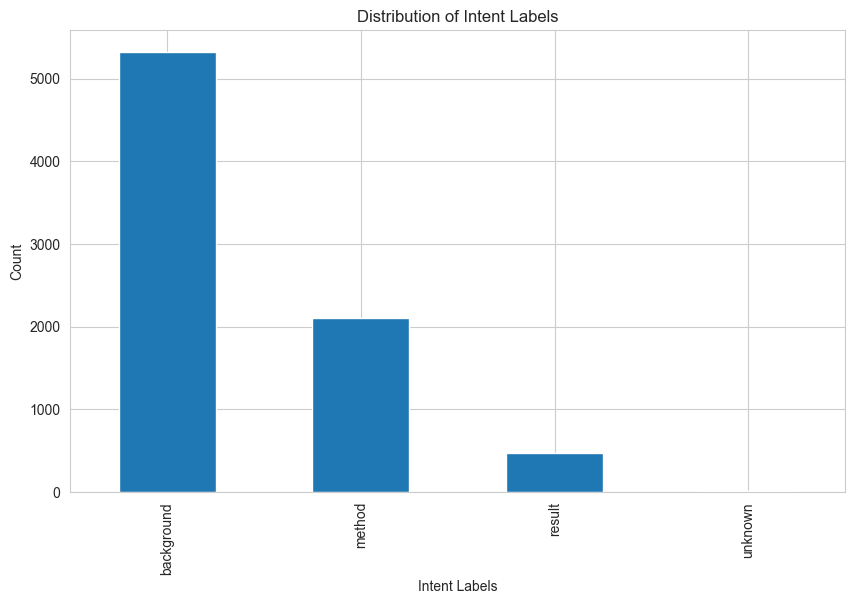

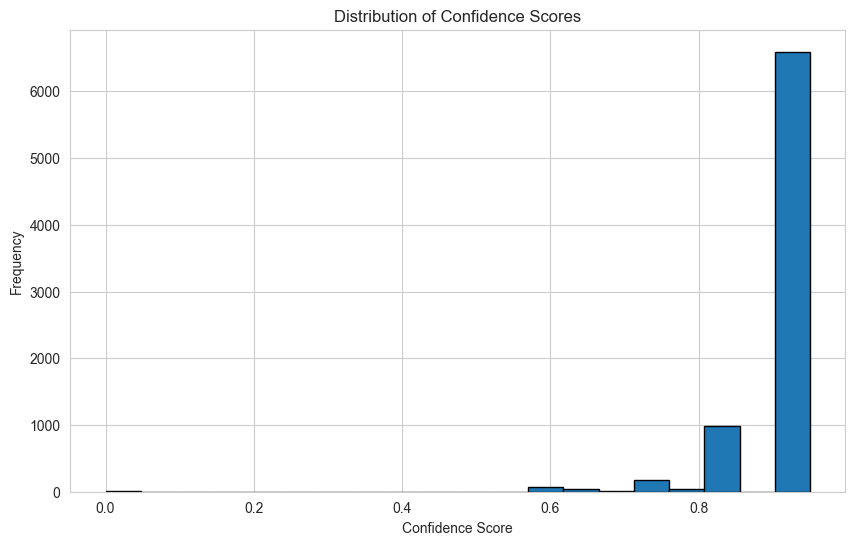

In [15]:
from collections import Counter
import matplotlib.pyplot as plt

# Count the occurrences of each intent label
intent_counts = df_intent['intent'].value_counts()

# Plot the distribution of intent labels
plt.figure(figsize=(10, 6))
intent_counts.plot(kind='bar')
plt.xlabel('Intent Labels')
plt.ylabel('Count')
plt.title('Distribution of Intent Labels')
plt.show()

# Plot the distribution of confidence scores
plt.figure(figsize=(10, 6))
df_intent['confidence'].plot(kind='hist', bins=20, edgecolor='black')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.title('Distribution of Confidence Scores')
plt.show()

In [16]:
# Display rows with the label 'unknown'
unknown_samples = df_intent[df_intent['intent'] == 'unknown']
print("Samples with 'unknown' intent:")
unknown_samples

Samples with 'unknown' intent:


,text,sentiment,intent,confidence
252,A large corpus is vahmble as a source of such ...,0,unknown,0.75
521,Due to space we do not describe step 8 in deta...,0,unknown,0.60
540,A similar observation was made in .,0,unknown,0.60
573,6 Concluding remarks Our work presents a set o...,0,unknown,0.00
1088,791 and score the alignment template models ph...,0,unknown,0.65
1132,The other 5 have been suggested for Dutch by .,0,unknown,0.75
1913,Given a manually compiled lexicon containing w...,0,unknown,0.00
3009,of the position infer marion of words at ltlat .,0,unknown,0.95
3629,While these are based on a relatively few numb...,0,unknown,0.00
4179,also worked on one of our data sets.,0,unknown,0.60


In [17]:
# Display rows with confidence score below 0.8
low_confidence_samples = df_intent[df_intent['confidence'] < 0.8]
print("\nSamples with confidence score below 0.8:")
low_confidence_samples


Samples with confidence score below 0.8:


,text,sentiment,intent,confidence
8,Not only many combinations are found in the co...,0,background,0.78
63,As with other randomised models we construct q...,0,background,0.75
66,0.19-0.48 Leacock & Chodrow 0.36 Lin 0.3...,0,background,0.70
164,3 China’s role in Apple’s global supply chain ...,1,background,0.65
177,", and others identifying non-anaphoric defini...",0,background,0.75
...,...,...,...,...
7800,Lexical Weighting: the lexical weight a27 a1...,0,background,0.75
7823,We can then state the following theorem for ...,0,background,0.65
7824,Another way to look the algorithm is from the ...,0,background,0.60
7837,what does student want to write your Figure 3:...,0,background,0.65


In [18]:
# df_intent = df_intent[df_intent['intent'] != 'unknown'] # Remove unknown intent labels
# df_intent = df_intent[df_intent['confidence'] >= 0.8] # Filter out low confidence scores
# print(df_intent)

## CSA_raw_dataset

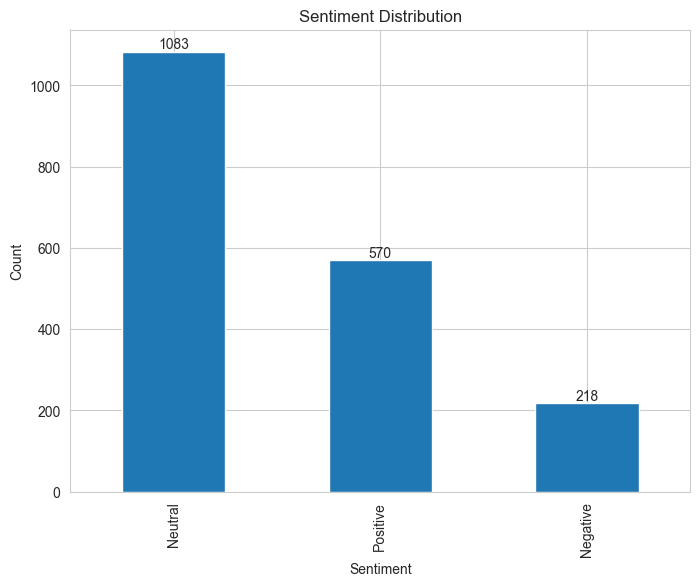

In [70]:
df_neutral = pd.read_csv('CSA_raw_dataset/athar_context_full_derived/NEUTRAL.csv')
df_negative = pd.read_csv('CSA_raw_dataset/athar_context_full_derived/NEGATIVE.csv')
df_positive = pd.read_csv('CSA_raw_dataset/athar_context_full_derived/POSITIVE.csv')
df_neutral['Sentiment'] = 'Neutral'
df_negative['Sentiment'] = 'Negative'
df_positive['Sentiment'] = 'Positive'

df_neutral.columns = ['Text'] + list(df_neutral.columns[1:])
df_negative.columns = ['Text'] + list(df_negative.columns[1:])
df_positive.columns = ['Text'] + list(df_positive.columns[1:])

df_combined = pd.concat([df_neutral[['Text', 'Sentiment']], df_negative[['Text', 'Sentiment']], df_positive[['Text', 'Sentiment']]], ignore_index=True)
df_combined = df_combined.sample(frac=1).reset_index(drop=True) # Shuffle the rows
df_combined.to_csv('CSA_raw_dataset/athar_context_full_derived/combined.csv', index=False)
sentiment_counts = df_combined['Sentiment'].value_counts()

fig, ax = plt.subplots(figsize=(8, 6))
sentiment_counts.plot(kind='bar', ax=ax)
for i, count in enumerate(sentiment_counts):
    ax.text(i, count, str(count), ha='center', va='bottom')

plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()

In [71]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1871 entries, 0 to 1870
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       1871 non-null   object
 1   Sentiment  1871 non-null   object
dtypes: object(2)
memory usage: 29.4+ KB


In [72]:
df_combined.head()

,Text,Sentiment
0,However due to the challenges in providing sem...,Positive
1,As the tagger of can not tag a word lattice ...,Negative
2,Edmunson 1969 proposed the use of other featur...,Neutral
3,In the news domain sentence location is the si...,Negative
4,Although we also use a mentionpair model our t...,Neutral
